In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import Xception,MobileNetV2,NASNetMobile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

import numpy as np
import os
import seaborn as sns
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import SimpleITK as sitk
import pathlib

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

In [2]:
df = pd.read_csv('D:/Blood_1/Classify_Results.csv')
df.head(10)

,Image ID,Class,Score(%)
0,100109202001_Blue_Lane [1]_RackIndex[1]_Date_0...,Blue,100.0000
1,100109202001_Blue_Lane [5]_RackIndex[15]_Date_...,Blue,100.0000
2,100109202001_White_Lane [1]_RackIndex[1]_Date_...,White,99.9997
3,100109202001_White_Lane [5]_RackIndex[15]_Date...,White,99.9997
4,100109202002_Blue_Lane [1]_RackIndex[2]_Date_0...,Blue,99.9999
5,100109202002_Blue_Lane [5]_RackIndex[14]_Date_...,Blue,100.0000
6,100109202002_White_Lane [1]_RackIndex[2]_Date_...,White,99.9998
7,100109202002_White_Lane [5]_RackIndex[14]_Date...,White,99.9997
8,100109202003_Blue_Lane [1]_RackIndex[3]_Date_0...,Blue,100.0000
9,100109202003_Blue_Lane [5]_RackIndex[11]_Date_...,Blue,100.0000


White    473
Blue     467
Name: Class, dtype: int64


<AxesSubplot:xlabel='Class', ylabel='count'>

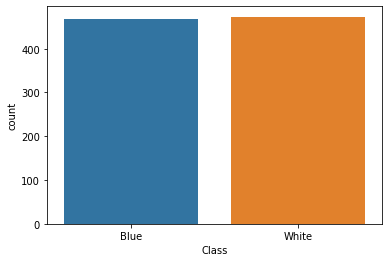

In [3]:
unique_count = df['Class'].value_counts()

print( unique_count)

sns.countplot(x = 'Class', data = df)

In [4]:
df['Class']=df.Class.map({'Blue':0,'White':1})
df.head()

,Image ID,Class,Score(%)
0,100109202001_Blue_Lane [1]_RackIndex[1]_Date_0...,0,100.0000
1,100109202001_Blue_Lane [5]_RackIndex[15]_Date_...,0,100.0000
2,100109202001_White_Lane [1]_RackIndex[1]_Date_...,1,99.9997
3,100109202001_White_Lane [5]_RackIndex[15]_Date...,1,99.9997
4,100109202002_Blue_Lane [1]_RackIndex[2]_Date_0...,0,99.9999


In [5]:
path = 'D:/Blood_1/Classify_Images/'
image_size = 224

X , y = [], []

for i,item in df.iterrows():

    image = sitk.ReadImage(path + item[0] + '.png')
    image = sitk.GetArrayFromImage(image)
    image = preprocess_input(image)
    image = cv.resize(image,(image_size,image_size))
    X.append(image)
    y.append(item[1])
    
X = np.array(X)
y = np.array(y)
y = np.expand_dims(y,axis=1)

In [6]:
print(X.shape)
print(y.shape)

(940, 224, 224, 3)
(940, 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0]


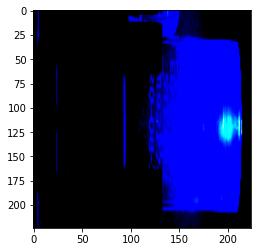

In [7]:
plt.imshow(X[5])
plt.show
print(y[5])

In [8]:
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,test_size=0.2)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(752, 224, 224, 3)
(188, 224, 224, 3)
(752, 1)
(188, 1)


In [9]:
y_train.shape

(752, 1)

In [10]:
input_shape=[224,224]

base_model = MobileNetV2 (input_shape = input_shape+[3], weights = 'imagenet', include_top = False)

x = base_model.output

x = GlobalAveragePooling2D()(x)

x = Dense(1024,activation='relu')(x)
x = Dropout(0.2)(x)

# and a logistic layer
out = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=out)

In [11]:
def scheduler(epoch):
    if epoch < 30:
        return 0.0001
    else:
        return 0.0001 * tf.math.exp(0.1 * (10 - epoch))

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)

stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)

In [12]:
model.compile(optimizer='adam', loss="binary_crossentropy", metrics=["accuracy"])
model.summary()  

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [13]:
callbacks = tf.keras.callbacks.ModelCheckpoint('Mobilenet.h5', monitor='val_loss', verbose=1, save_best_only=True, mode = 'auto')

batch_size = 4

r = model.fit(X_train,y_train, validation_data=(X_test,y_test), 
                        batch_size=batch_size, epochs= 50, 
                        callbacks = [callbacks,lr_schedule,stopping])

Epoch 1/50
186/188 [============================>.] - ETA: 0s - loss: 0.1386 - accuracy: 0.9328 ETA: 2s - loss: 0.2177 - ac - ETA: 2s - loss: 0.1852 - accuracy: 0.90 - ETA:  - ETA: 
Epoch 00001: val_loss improved from inf to 0.02994, saving model to Mobilenet.h5
188/188 [==============================] - 6s 30ms/step - loss: 0.1375 - accuracy: 0.9335 - val_loss: 0.0299 - val_accuracy: 0.9894
Epoch 2/50
187/188 [============================>.] - ETA: 0s - loss: 0.0367 - accuracy: 0.9878 ETA: 3s - loss: 0 - ETA: 1s - loss: 0 - ETA: 0s - loss: 0.0387 - accu - ETA: 0s - loss: 0.0361 - accuracy: 0.9880
Epoch 00002: val_loss did not improve from 0.02994
188/188 [==============================] - 5s 25ms/step - loss: 0.0359 - accuracy: 0.9880 - val_loss: 0.1019 - val_accuracy: 0.9628
Epoch 3/50
188/188 [==============================] - ETA: 0s - loss: 0.0030 - accuracy: 1.0000 ETA: 1s - loss: 0.0032 - accuracy: 
Epoch 00003: val_loss improved from 0.02994 to 0.01550, saving model to Mobilene

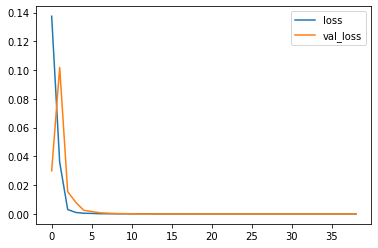

In [14]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

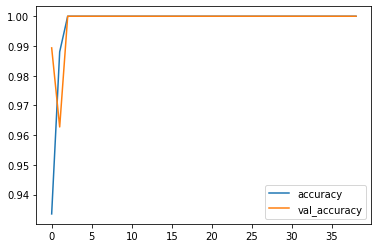

In [15]:
plt.plot(r.history['accuracy'],label='accuracy')
plt.plot(r.history['val_accuracy'],label='val_accuracy')
plt.legend()

In [16]:
P= model.predict(X_test,batch_size=4)

In [17]:
Pred = np.where(P<0.5,0,1)

([<matplotlib.axis.YTick at 0x2656f38ea48>,
 [Text(0, 0, 'Blue'), Text(0, 1, 'White')])

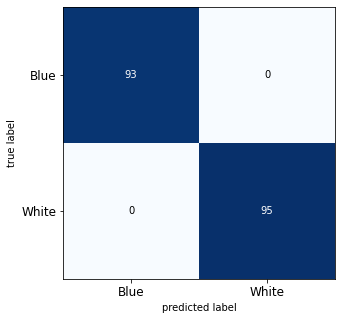

In [18]:
matrix = confusion_matrix (y_test, Pred)
plot_confusion_matrix(matrix, figsize=(5,5))
plt.xticks(range(2), ['Blue','White'], fontsize=12)
plt.yticks(range(2), ['Blue','White'], fontsize=12)

### Resize Tensor

In [19]:
TF_LITE_MODEL_FILE_NAME = "model.tflite"

In [20]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tf_lite_converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = tf_lite_converter.convert()

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Users\ASARKA~1.NAT\AppData\Local\Temp\tmpahd89m3u\assets


In [21]:
tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

3622448

In [22]:
interpreter = tf.lite.Interpreter(model_path = TF_LITE_MODEL_FILE_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1 224 224   3]
Input Type: <class 'numpy.float32'>
Output Shape: [1 1]
Output Type: <class 'numpy.float32'>


In [23]:
interpreter.resize_tensor_input(input_details[0]['index'], (188, 224, 224,3))
interpreter.resize_tensor_input(output_details[0]['index'], (188, 1))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [188 224 224   3]
Input Type: <class 'numpy.float32'>
Output Shape: [188   1]
Output Type: <class 'numpy.float32'>


In [24]:
X_test.dtype

dtype('float32')

In [25]:
interpreter.set_tensor(input_details[0]['index'], X_test)
interpreter.invoke()
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes = np.where(tflite_model_predictions<0.5, 0,1)

Prediction results shape: (188, 1)


In [26]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(prediction_classes, y_test)

In [27]:
print('Test accuracy TFLITE model :', acc)

Test accuracy TFLITE model : 1.0
